# 3.6 주택 가격 예측: 회귀 문제 예제

3.6.1 이 예제에서 사용되는 데이터가 무엇인가?
 - 보스턴 외곽 지역의 범죄율, 지방세율, 주택당 평균 방의 개수, 고속도록 접근성등 13개의 특성을 가지고있는 데이터입니다.

3.6.2 이 예제에서 예측하고자 하는 방법/방향이 무엇인가?
 - 특정 데이터가 주어졌을 때 학습한 머신을 이용하여 주택 가격의 중간 값을 예측하고자 하는것입니다. 

3.6.3 이 예제에서 학습을 위해 데이터가 어떻게 가공/처리 되었는가?
 - 학습을 시키기 위해서 정규화 작업을 하였으며 정규화 방식은 각 특성의 평균을 빼고 표준 편차로 나누었습니다.
 - 현재 제공하고 있는 데이터가 많지 않기 때문에 K-겹 교차 검증을 사용
 - K-겹 교차는 데이터를 K개의 분할로 나누고 K개의 모델을 각각 만들어 K-1개의 분할에서 훈련하고 나머지 분할에서 평가하는 방법

3.6.4 사용된 모델의 입력층과 출력층이 무엇인가?
 - 입력층은 13개의 특성을 가진 데이터입니다.
 - 출력층은 특정 데이터가 입력되었을 때 그 데이터의 결과로 인하여 나타나는 주택 가격의 중간 값을 예측하는 층입니다.

In [2]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# 총 506개의 데이터 중 404개는 훈련 데이터, 102개는 테스트 데이터로 구성되어 있음
# 데이터의 단위는 천 달러 단위임
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

Using TensorFlow backend.


In [3]:
#데이터를 사용하기 위해 정규화 작업을 진행
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
#테스트 데이터는 훈련 데이터에서 진행하였던 정규화 데이터의 값을 그대로 적용 그 이유는 실전과 똑같이 적용시키기 위함

test_data -= mean
test_data /= std

In [4]:
#마지막 층에 활성화 함수가 없는데 이러한 모습은 전형적인 스칼라 회귀를 위한 구성
def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [8]:
# k-겹 겸증
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [9]:
#K-겹 검증 점수 평균 기록
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

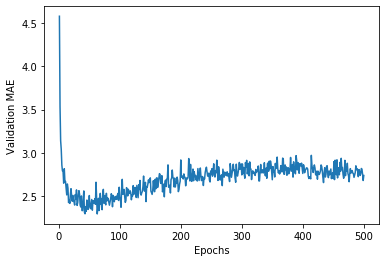

In [13]:
#에포크별 검즘 MAE 그래프로 표현
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

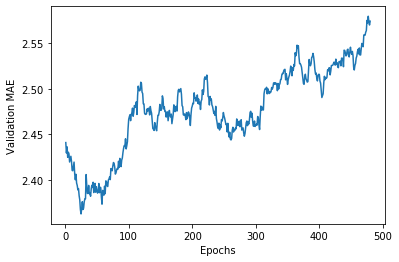

In [10]:
# 그래프의 범위가 크고 변동이 심하여 지수 이동 평균(시계열 데이터를 부드럽게 만드는 기법 중 하나)으로 대체
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
# 이번 실습에서는 500번만 했기때문에 기존 예제보다 더 많은 20개의 데이터 포인터를 제외
smooth_mae_history = smooth_curve(average_mae_history[20:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [8]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [9]:
#새롭게 컴파일된 모델에서 나타난 결과를 확인
test_mae_score

2.964918987423766

# 3.6 예제 종료